In [330]:
import gzip
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

# 2.1 Dataset Preparation & Analysis

### 2.1.1.2 Dataset Loading

In [2]:
file = gzip.open('goemotions.json.gz')
json_file = json.load(file)

### 2.1.1.3 Posts, Labels Extraction and Plots

In [3]:
emotions = np.array([])
sentiments = np.array([])
posts = np.array([1])
json_file = np.asarray(json_file)

posts = json_file[:,0]
emotions = json_file[:,1]
sentiments = json_file[:,2]

In [ ]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
plt.hist(emotions, bins=range(29), align="left", ec="white")
plt.xticks(rotation=45, ha="right")
plt.ylabel("number of posts")
plt.title("Distribution of the Emotion Label")
plt.savefig("emotion.pdf", format="pdf")
plt.show()
plt.ylabel("number of posts")
plt.hist(sentiments, bins=range(5), align="left", ec="white")
plt.title("Distribution of the Sentiment Label")
plt.savefig("sentiment.pdf", format="pdf")
plt.show()

# 2.2 Words as Features

#### Vectorizer
Extracts all the tokens from each post and returns a term matrix.

In [4]:
vectorizer = CountVectorizer()

In [5]:
text_dataset = vectorizer.fit_transform(posts)

#### Data Preparation

In [6]:
sentiments_vectorizer = CountVectorizer()
sentiments_vectorizer.fit_transform(sentiments)

emotions_vectorizer = CountVectorizer()
emotions_vectorizer.fit_transform(emotions)

<171820x28 sparse matrix of type '<class 'numpy.int64'>'
	with 171820 stored elements in Compressed Sparse Row format>

#### Labels to Integers Conversion and Data Splitting

`posts_train`/`test` training and testing sets for the inputs  
`emotions_train`/`test` training and testing sets for the emotion labels  
`sentiments_train`/`test` training and testing sets for the sentiment labels

In [7]:
sentiments_index = np.asarray(list(map(lambda s: sentiments_vectorizer.vocabulary_[s], sentiments)))
emotions_index = np.asarray(list(map(lambda e: emotions_vectorizer.vocabulary_[e], emotions)))

sentiments_train, sentiments_test = train_test_split(sentiments_index,train_size=0.8)
emotions_train, emotions_test = train_test_split(emotions_index, train_size=0.8)
posts_train, posts_test = train_test_split(text_dataset,train_size=0.8)

## 2.2.3 Training and Testing

In [11]:
mlp_model_base_e = MLPClassifier(max_iter=20)
mlp_model_base_s = MLPClassifier(max_iter=20)

### 2.2.3.3 Base-MLP
Training with default parameters.

#### Emotions Classification

In [12]:
mlp_model_base_e.fit(posts_train, emotions_train)

C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=20)

#### Sentiments Classification

In [13]:
mlp_model_base_s.fit(posts_train, sentiments_train)

C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=20)

### 2.2.3.6 Top-MLP
Using `GridSearchCV` to cross-validate the model with the most optimal hyperparameters.

**Hidden Layers:** (30, 50,), (10, 10, 10,)  
**Activation Functions:** sigmoid, tanh, ReLU, identity  
**Optimisers:** adam, sgd

In [14]:
parameters = {'hidden_layer_sizes': [(30, 50,), (10, 10, 10,)],
                'activation': ['logistic', 'tanh', 'relu', 'identity'],
                 'solver': ['sgd', 'adam']}
mlp = MLPClassifier(max_iter=20)

mlp_model_top_e = GridSearchCV(estimator = mlp, param_grid = parameters, n_jobs=-1)
mlp_model_top_s = GridSearchCV(mlp, parameters)

#### Emotions Classification

In [15]:
mlp_model_top_e.fit(posts_train, emotions_train)

GridSearchCV(estimator=MLPClassifier(max_iter=20), n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh', 'relu', 'identity'],
                         'hidden_layer_sizes': [(30, 50), (10, 10, 10)],
                         'solver': ['sgd', 'adam']})

#### Sentiments Classification

In [16]:
mlp_model_top_s.fit(posts_train, sentiments_train)

C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

GridSearchCV(estimator=MLPClassifier(max_iter=20),
             param_grid={'activation': ['logistic', 'tanh', 'relu', 'identity'],
                         'hidden_layer_sizes': [(30, 50), (10, 10, 10)],
                         'solver': ['sgd', 'adam']})

## 2.2.4 Saving Performance

#### Predictions

In [223]:
pred_base_e = mlp_model_base_e.predict(posts_test)
pred_base_s = mlp_model_base_s.predict(posts_test)
pred_top_e = mlp_model_top_e.predict(posts_test)
pred_top_s = mlp_model_top_s.predict(posts_test)

#### Keys Retrieval
Gets the key (emotion/sentiment) given a value (index in `vocabulary_`).

`emotion_classes` all the emotion labels  
`sentiment_classes` all the sentiment labels

In [179]:
def getKey(d, value):
    for i in list(range(len(d))):
        k, v = list(d.items())[i]
        if v == value:
            return k

emotion_classes = list(map(lambda v : getKey(emotions_vectorizer.vocabulary_, v), mlp_model_base_e.classes_))
sentiment_classes = list(map(lambda v : getKey(sentiments_vectorizer.vocabulary_, v), mlp_model_base_s.classes_))

#### Models Description

In [224]:
models = [mlp_model_base_e, mlp_model_base_s, mlp_model_top_e, mlp_model_top_s]

with open('mlp_performance.txt', 'w') as f:
    f.write("Base MLP for emotions classification\nDefault parameters\n"
           + "----------------------------------------------------\n")
    f.write(str(classification_report(y_true=emotions_test, y_pred=pred_base_e, target_names=emotion_classes)))
    f.write("=====================================================\n\n")
    
    f.write("Base MLP for sentiments classification\nDefault parameters\n"
           + "-----------------------------------------------------\n")
    f.write(str(classification_report(y_true=sentiments_test, y_pred=pred_base_s, target_names=sentiment_classes)))
    f.write("=====================================================\n\n")
    
    f.write("Top MLP for emotions classification\n" + str(mlp_model_top_e.best_params_) + "\n"
           + "-----------------------------------------------------\n")
    f.write(str(classification_report(y_true=emotions_test, y_pred=pred_top_e, target_names=emotion_classes)))
    f.write("=====================================================\n\n")
    
    f.write("Top MLP for sentiments classification\n" + str(mlp_model_top_s.best_params_) + "\n"
           + "-----------------------------------------------------\n")
    f.write(str(classification_report(y_true=sentiments_test, y_pred=pred_top_s, target_names=sentiment_classes)))
    f.write("=====================================================\n\n")

C:\Users\vatan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\metr

#### Confusion Matrices

TypeError: 'AxesSubplot' object is not subscriptable

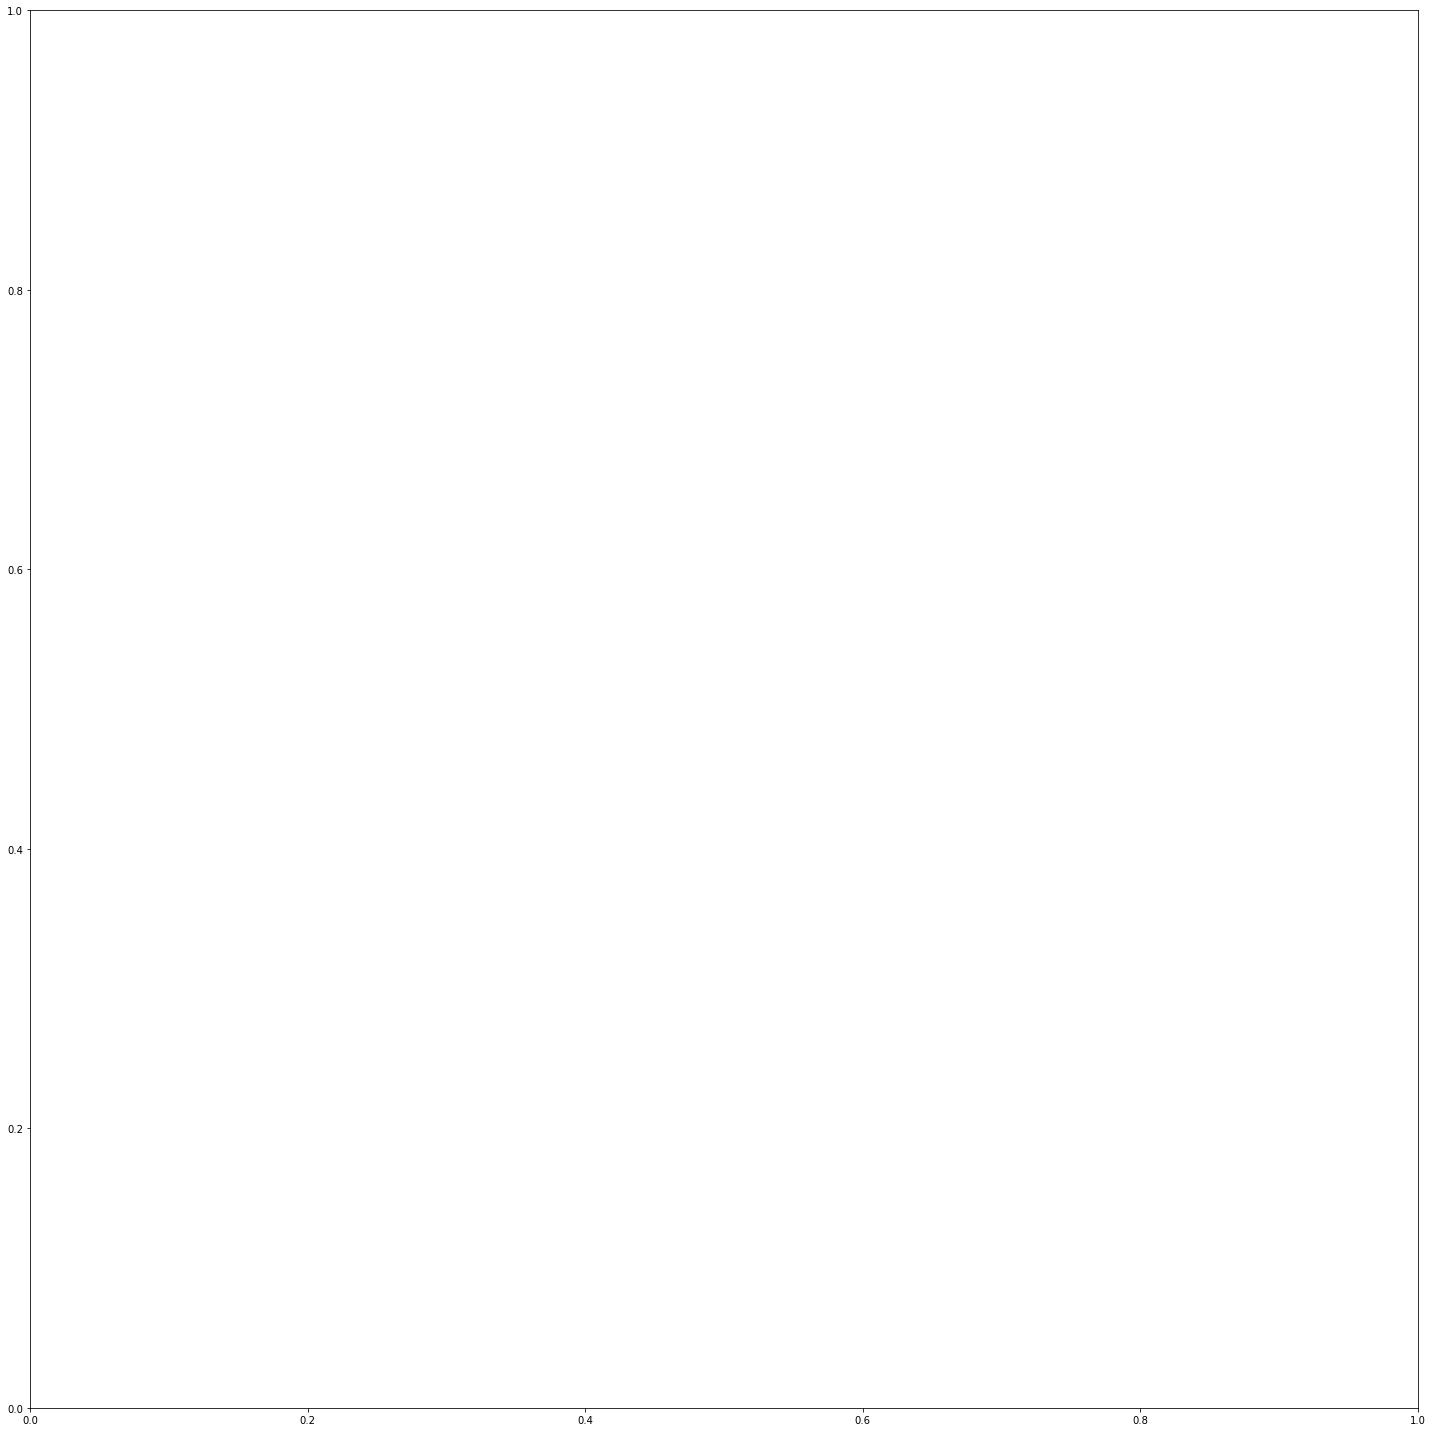

In [329]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classifiers = {
#     "Base MLP for Emotions Classification": mlp_model_base_e,
#     "Top MLP for Emotions Classification": mlp_model_top_e,
#     "Base MLP for Sentiments Classification": mlp_model_base_s,
#     "Top MLP for Sentiments Classification": mlp_model_top_s,
    
#     "Base MLP for Emotions Classification with Stopwords": mlp_model_base_e_new,
#     "Top MLP for Emotions Classification with Stopwords": mlp_model_top_e_new,
#     "Base MLP for Sentiments Classification with Stopwords": mlp_model_base_s_new,
#     "Top MLP for Sentiments Classification with Stopwords": mlp_model_top_s_new,
}

y_test = [
#             emotions_test, 
#             emotions_test, 
#             sentiments_test, 
#             sentiments_test,
    
#             emotions_test, 
#             emotions_test, 
#             sentiments_test, 
#             sentiments_test,
         ]
y_pred = [
#             pred_base_e, 
#             pred_top_e, 
#             pred_base_s, 
#             pred_top_s,
    
#             pred_base_e_new, 
#             pred_top_e_new, 
#             pred_base_s_new, 
#             pred_top_s_new,
         ]
labels = [
#             emotion_classes, 
#             emotion_classes, 
#             sentiment_classes, 
#             sentiment_classes,
    
#             emotion_classes, 
#             emotion_classes, 
#             sentiment_classes, 
#             sentiment_classes,
         ]

f, axes = plt.subplots(1, 2, figsize=(20, 20), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    cf_matrix = confusion_matrix(y_test[i], y_pred[i])
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=labels[i])
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.5, 0.2, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.4)


# f.colorbar(disp.im_, shrink=0.7, ax=axes)
plt.savefig("Confusion Matrix for Emotions Classification.pdf", format="pdf")
plt.show()


## 2.2.5 Exploration
Removing stop words and redoing the **2.3.3**

In [188]:
vectorizer_new = CountVectorizer(stop_words='english')

In [189]:
text_dataset_new = vectorizer_new.fit_transform(posts)

In [194]:
posts_train_new, posts_test_new = train_test_split(text_dataset_new,train_size=0.8)

In [195]:
mlp_model_base_e_new = MLPClassifier(max_iter=20)
mlp_model_base_s_new = MLPClassifier(max_iter=20)

In [196]:
mlp_model_base_e_new.fit(posts_train_new, emotions_train)

C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=20)

In [197]:
mlp_model_base_s_new.fit(posts_train_new, sentiments_train)

C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=20)

In [198]:
parameters = {'hidden_layer_sizes': [(30, 50,), (10, 10, 10,)],
                'activation': ['logistic', 'tanh', 'relu', 'identity'],
                 'solver': ['sgd', 'adam']}
mlp_new = MLPClassifier(max_iter=20)

mlp_model_top_e_new = GridSearchCV(estimator = mlp_new, param_grid = parameters, n_jobs=-1)
mlp_model_top_s_new = GridSearchCV(mlp_new, parameters)

In [199]:
mlp_model_top_e_new.fit(posts_train_new, emotions_train)

GridSearchCV(estimator=MLPClassifier(max_iter=20), n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh', 'relu', 'identity'],
                         'hidden_layer_sizes': [(30, 50), (10, 10, 10)],
                         'solver': ['sgd', 'adam']})

In [200]:
mlp_model_top_s_new.fit(posts_train_new, sentiments_train)

C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

GridSearchCV(estimator=MLPClassifier(max_iter=20),
             param_grid={'activation': ['logistic', 'tanh', 'relu', 'identity'],
                         'hidden_layer_sizes': [(30, 50), (10, 10, 10)],
                         'solver': ['sgd', 'adam']})

#### Predictions

In [229]:
pred_base_e_new = mlp_model_base_e_new.predict(posts_test_new)
pred_base_s_new = mlp_model_base_s_new.predict(posts_test_new)
pred_top_e_new = mlp_model_top_e_new.predict(posts_test_new)
pred_top_s_new = mlp_model_top_s_new.predict(posts_test_new)

#### Saving to Performance File

In [ ]:
with open('mlp_performance.txt', 'a') as f:
    f.write("Base MLP for emotions classification with stopwords\nDefault parameters\n"
           + "----------------------------------------------------\n")
    f.write(str(classification_report(y_true=emotions_test, y_pred=pred_base_e_new, target_names=emotion_classes)))
    f.write("=====================================================\n\n")
    
    f.write("Base MLP for sentiments classification with stopwords\nDefault parameters\n"
           + "-----------------------------------------------------\n")
    f.write(str(classification_report(y_true=sentiments_test, y_pred=pred_base_s_new, target_names=sentiment_classes)))
    f.write("=====================================================\n\n")
    
    f.write("Top MLP for emotions classification with stopwords\n" + str(mlp_model_top_e_new.best_params_) + "\n"
           + "-----------------------------------------------------\n")
    f.write(str(classification_report(y_true=emotions_test, y_pred=pred_top_e_new, target_names=emotion_classes)))
    f.write("=====================================================\n\n")
    
    f.write("Top MLP for sentiments classification with stopwords\n" + str(mlp_model_top_s_new.best_params_) + "\n"
           + "-----------------------------------------------------\n")
    f.write(str(classification_report(y_true=sentiments_test, y_pred=pred_top_s_new, target_names=sentiment_classes)))
    f.write("=====================================================\n\n")

# 2.3 Embeddings as Features

In [299]:
import gensim.downloader as api
w2v_model = api.load("word2vec-google-news-300")

import nltk
nltk.download()

word_tokens = [nltk.word_tokenize(corpus, language="english") for corpus in X_train]

def get_post_embedding(model, post):
    tokens = nltk.word_tokenize(post)
    words = [word for word in tokens if word in model]
    if len(words)>0:
        return np.mean(model[words], axis=0)
    else:
        return model['unk']

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [300]:
X_train, X_test = train_test_split(posts,train_size=0.8)

training_post_embeddings = [get_post_embedding(w2v_model, post) for post in X_train]
testing_post_embeddings = [get_post_embedding(w2v_model, post) for post in X_test]

## 2.3.6 Training Top-MLP

**Hidden Layers:** (10, 10, 10,)  
**Activation Functions:** ReLU  
**Optimisers:** adam

In [304]:
mlp_model_top_e_em = MLPClassifier(hidden_layer_sizes=(10, 10, 10,), activation='relu', solver='adam', max_iter=20)
mlp_model_top_s_em = MLPClassifier(hidden_layer_sizes=(10, 10, 10,), activation='relu', solver='adam', max_iter=20)

In [321]:
mlp_model_top_e_em.fit(training_post_embeddings, emotions_train)
mlp_model_top_s_em.fit(training_post_embeddings, sentiments_train)

C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=20)

In [322]:
pred_top_e_em = mlp_model_top_e_em.predict(testing_post_embeddings)
pred_top_s_em = mlp_model_top_s_em.predict(testing_post_embeddings)

In [324]:
params = {
    'hidden_layer_sizes': (10, 10, 10,),
    'activation': 'relu',
    'solver': 'adam'
}

with open('mlp_performance.txt', 'a') as f:
    f.write("=====================================================\n\n")
    
    f.write("Top MLP for emotions classification with word embeddings\n" + str(params) + "\n"
           + "-----------------------------------------------------\n")
    f.write(str(classification_report(y_true=emotions_test, y_pred=pred_top_e_em, target_names=emotion_classes)))
    f.write("=====================================================\n\n")
    
    f.write("Top MLP for sentiments classification with word embeddings\n" + str(params) + "\n"
           + "-----------------------------------------------------\n")
    f.write(str(classification_report(y_true=sentiments_test, y_pred=pred_top_s_em, target_names=sentiment_classes)))
    f.write("=====================================================\n\n")

C:\Users\vatan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vatan\anaconda3\lib\site-packages\sklearn\metr

In [ ]:
# import pickle

# models = [mlp_model_base_e, mlp_model_base_s, mlp_model_top_e, mlp_model_top_s, mlp_model_base_e_new, mlp_model_base_s_new, mlp_model_top_e_new, mlp_model_top_s_new]
# mlp = 'finalised_mlp_models.sav'
# pickle.dump(models, open(mlp, 'wb'))

In [ ]:
# models = pickle.load(open('finalised_mlp_models.sav', 'rb'))
# result = models[0].score()
# print(result)

In [236]:
# def getNumber(array, sentiment):
#     sentiment_list = list(map(lambda s: s==sentiment, array))
#     count = 0
#     for s in sentiment_list:
#         if s == True:
#             count += 1
#     return count